In [2]:
import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn

# Hello world -- Learn a line!

As a first test I want to do the simplest possible equation I can think of, a line.

Lines show up in physics as the steady state solution of heat equations in 1D.  Normally the heat equation is $dy/dt=d^2y/dx^2$ but since we want the steady state equation let $dy=dt=0$. But we also want to anchor the line so it doesn't go where ever so I'll give it some boundary conditions of $y(0)=0$ and $y(1)=1$.

Physically this would correspond to something like a metal bar that is heated to a temperature of 0 on one end and 1 on the other end and let to sit for a long time.

In [4]:
class Unsqueeze(nn.Module):
    """Unsqueeze a tensor along a given dimension."""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        return x.unsqueeze(self.dim)

class Squeeze(nn.Module):
    """Squeeze a tensor along a given dimension."""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, x):
        return x.squeeze(self.dim)


In [53]:
def create_1d_network(num_layers: int=4, num_channels: int=32, activation=nn.SiLU, device="cuda") -> torch.nn.Module:
    """Create a 1d network"""
    layers = []

    # Add channel dimenion
    layers.append(Unsqueeze(dim=1))

    layers.append(nn.Linear(1, num_channels))
    layers.append(activation())

    for _ in range(num_layers - 1):
        layers.append(nn.Linear(num_channels, num_channels))
        layers.append(activation())

    # Final layer to reduce to single output channel
    layers.append(nn.Linear(num_channels, 1))

    # Remove channel dimension
    layers.append(Squeeze(dim=1))
    
    network = nn.Sequential(*layers)
    return network.to(device)


# Example usage
device = "cuda" if torch.cuda.is_available() else "cpu"
network = create_1d_network(device=device)

points = torch.linspace(0, 1, steps=10, device=device).unsqueeze(-1)  # Shape (100, 1
network(points)  # Forward pass to check everything works

tensor([[0.0682],
        [0.0683],
        [0.0684],
        [0.0685],
        [0.0686],
        [0.0687],
        [0.0687],
        [0.0687],
        [0.0686],
        [0.0686]], device='cuda:0', grad_fn=<SqueezeBackward1>)

In [100]:
# Training loop for a simple 1D PINN solving a boundary value problem
network = create_1d_network(device=device)
num_points_per_batch = 1000
num_epochs = 1000
optimizer = torch.optim.Adam(network.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
mse_loss = nn.MSELoss()

# Boundary conditions at x=0 and x=1
x_bc = torch.tensor([0.0, 1.0], device=device)
y_bc = torch.tensor([0.0, 1.0], device=device)

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Input values
    interior_times = torch.rand(num_points_per_batch - 2, device=device, requires_grad=True)
    sampled_times = torch.cat([x_bc, interior_times], dim=0)

    # Forward pass
    displacement_pred = network(sampled_times)

    # Compute the residual of the differential equation
    dx_dt = torch.autograd.grad(displacement_pred, sampled_times, grad_outputs=torch.ones_like(displacement_pred), create_graph=True)[0]
    d2x_dt2 = torch.autograd.grad(dx_dt, sampled_times, grad_outputs=torch.ones_like(dx_dt), create_graph=True)[0]
    residual = d2x_dt2
    residual_loss = mse_loss(residual, torch.zeros_like(residual))  # PDE residual loss, e.g., for d2T/dx2 = 0

    # Compute the boundary conditions
    bc_loss = mse_loss(displacement_pred[:2] , y_bc)  # Boundary condition loss

    # Total loss
    loss = residual_loss + bc_loss

    # Backward pass and optimization step
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.499837726354599
Epoch 100, Loss: 0.0001845080405473709
Epoch 200, Loss: 7.295486739167245e-07
Epoch 300, Loss: 3.809276734045852e-07
Epoch 400, Loss: 2.3401132409617276e-07
Epoch 500, Loss: 2.1072776235087076e-07
Epoch 600, Loss: 1.8586177930046688e-07
Epoch 700, Loss: 1.7997579959683208e-07
Epoch 800, Loss: 1.6499747346188087e-07
Epoch 900, Loss: 1.7470078716996795e-07


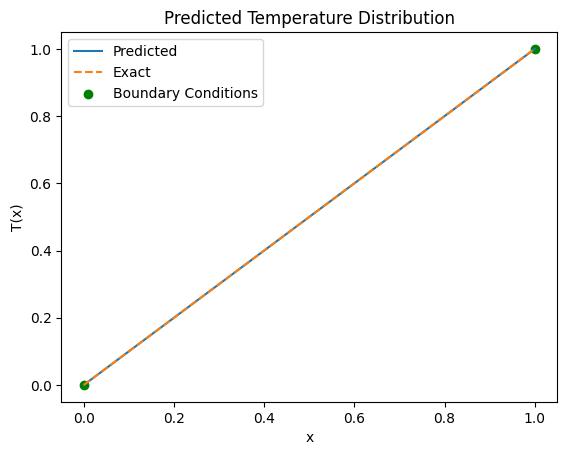

In [101]:
grid =  torch.linspace(0, 1, steps=100, device=device)

displacement_pred = network(grid)
plt.plot(grid.detach().cpu().numpy(), displacement_pred.detach().cpu().numpy(), label="Predicted")
plt.plot(grid.detach().cpu().numpy(), grid.detach().cpu().numpy(), label="Exact", linestyle='dashed')
plt.scatter([0, 1], [0, 1], color='green', label="Boundary Conditions")

plt.legend()
plt.xlabel("x")
plt.ylabel("T(x)")
plt.title("Predicted Temperature Distribution")
plt.show()

## Analysis

Looks like a neural network is about as good as linear regression for two points!

I used a smooth activation, SiLU (my favorite activation) instead of ReLU so that the derivatives would be as smooth as possible.

What I learned:

- I tried originally using a convolutional neural network with a grid. I found that the network didn't try to keep the derivative zero between the points on the grid, just on the grid points. That's why I switched to random sampling, nowhere for those pesky derivatives to hide!

- I originally thought about using numerical differentiation using neighboring points, then I realized how silly that is since neural networks can do derivatives. They are basically designed for them!

- I went back and tried with ReLU and the losses got lower but the plot was no longer a straight line. It still hit the boundary conditions and since the losses were super low I'm sure the second derivatives were getting low at virtually every point. But the point where the ReLU's second derivative aren't defined is enough to ruin everything, as I suspected.

# Upping the stakes -- damped harmonic oscillation

A damped harmonic oscillator satifies the equation:

$md^2x/dt^2+cdx/dt+kx=0$

where $m$ is the mass, $c$ is the damping coefficient, $k$ is the spring constant$, $x(t)$ is the displacement. The solutions are well known: https://en.wikipedia.org/wiki/Harmonic_oscillator.

I'll use the "dimensionless" form though:

$dx^2/dt^2+2\zeta\omega_0dx/dt+\omega_0^2=0$.

Here, $\omega_0$ is the "undamped angular frequency"--the frequency it would naturally osillate at without damping--and $zeta$ is the damping ratio. I'll have $\omega_0=2\pi$ and let $\zeta=0.8$ so that the system gets some oscillation and dies out.  I also need to define initial conditions, so I'll let $x(0)=0$ and $x'(0)=1$, which means I release the oscillator with a bit of a push from equilibrium position.

This problem is quite a bit different than the last from a mathematicaly perspective. Now the independent variable is time, not space, it is an initial value problem, not a boundary value problem, and the solution is more interesting than a line. Let's see how the old neurons do on this one!

In [103]:
# Training loop for a simple 1D PINN solving an initial value problem
network = create_1d_network(device=device)
num_points_per_batch = 1000
num_epochs = 1000
optimizer = torch.optim.Adam(network.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)
mse_loss = nn.MSELoss()

# Initial displacement at x=1
x_bc = torch.tensor([0.0], device=device)
y_bc = torch.tensor([0.0], device=device)  # Initial displacement at x=0
y_ic = torch.tensor([1.0], device=device)  # Initial velocity at x=0

# Physical parameters
zeta = 0.3  # Damping ratio
omega = 2 * np.pi  # Natural frequency
duration = 5.0  # Duration of the simulation

for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Input values
    interior_times = duration * torch.rand(num_points_per_batch - 2, device=device, requires_grad=True)
    sampled_times = torch.cat([x_bc, interior_times], dim=0)

    # Forward pass
    displacement_pred = network(sampled_times)

    # Compute the residual of the differential equation
    dx_dt = torch.autograd.grad(displacement_pred, sampled_times, grad_outputs=torch.ones_like(displacement_pred), create_graph=True)[0]
    d2x_dt2 = torch.autograd.grad(dx_dt, sampled_times, grad_outputs=torch.ones_like(dx_dt), create_graph=True)[0]
    residual = d2x_dt2 + 2*zeta*omega*dx_dt + omega**2*displacement_pred
    residual_loss = mse_loss(residual, torch.zeros_like(residual))  # PDE residual loss, e.g., for d2x_dt2 = 0

    # Compute the boundary conditions
    bc_loss = mse_loss(displacement_pred[:1] , y_bc)  # Boundary condition loss
    ic_loss = mse_loss(dx_dt[:1] , y_ic)  # Initial condition loss

    # Total loss
    loss = residual_loss + 10000*(bc_loss + ic_loss)

    # Backward pass and optimization step
    loss.backward()
    
    nn.utils.clip_grad_norm_(network.parameters(), max_norm=10.0)
    optimizer.step()
    scheduler.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 10313.958984375
Epoch 100, Loss: 31.456783294677734
Epoch 200, Loss: 40.36052703857422
Epoch 300, Loss: 22.256696701049805
Epoch 400, Loss: 13.854072570800781
Epoch 500, Loss: 7.413708209991455
Epoch 600, Loss: 5.342538833618164
Epoch 700, Loss: 0.6354919672012329
Epoch 800, Loss: 0.34039175510406494
Epoch 900, Loss: 0.12702110409736633


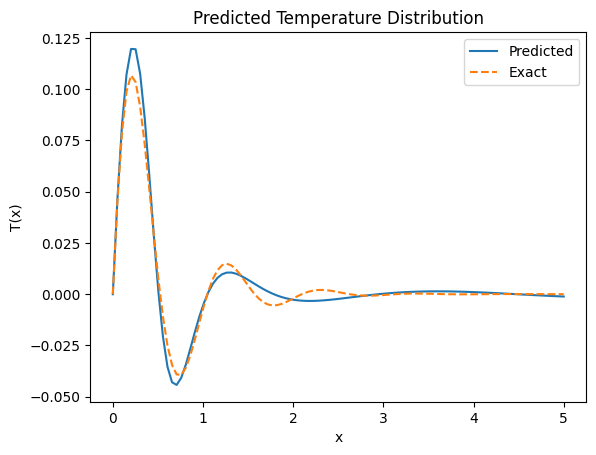

In [104]:
grid =  torch.linspace(0, duration, steps=100, device=device)
omega_d = omega * np.sqrt(1 - zeta**2)
C = 1 / omega_d
solution = torch.exp(-zeta*omega*grid) *C*torch.sin(omega_d*grid)

displacement_pred = network(grid)
plt.plot(grid.detach().cpu().numpy(), displacement_pred.detach().cpu().numpy(), label="Predicted")
plt.plot(grid.detach().cpu().numpy(), solution.detach().cpu().numpy(), label="Exact", linestyle='dashed')

plt.legend()
plt.xlabel("x")
plt.ylabel("T(x)")
plt.title("Predicted Temperature Distribution")
plt.show()

## Analysis

Well, the results aren't as nice as for the heat equation.

What I learned

- I had to increase the loss for the IC and BCs because their signal seemed to be drowned out by the number of other points

- The gradients were less stable than before,